In [1]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
from PIL import Image as pil_img
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import os
def preprocess_image(input_image):
    path = os.path.abspath(input_image)
    image = pil_img.open(path)
    image = image.resize((224, 224))

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Normalize the pixel values
    image_array = image_array / 255.0

    # Expand dimensions to match the model input shape
    input_image = np.expand_dims(image_array, axis=0)
    
    return input_image


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [3]:
import csv
import ast
def load_dict_from_csv(filename):
    dictionary = {}
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader)  # Skip header row
        for row in reader:
            key = row[0]
            value = ast.literal_eval(row[1])  # Convert value back to its original data type
            dictionary[key] = value
    return dictionary

# Load dictionary from CSV
loaded_dict = load_dict_from_csv('classes_dictionary.csv')
print(loaded_dict)

{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [4]:
def get_keys_by_value(dictionary, value):
    return [key for key, val in dictionary.items() if val == value]

In [5]:
def get_prediction_and_heatmap(image):
    # Prepare image
    img_array = preprocess_image(image)

    # Make model
    model = keras.models.load_model('VGG19_transfer_learning_animals10.h5')

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    prediction = model.predict(img_array)

    # Get the predicted class label
    predicted_class = np.argmax(prediction)
    #print(predicted_class)
    animal_name = get_keys_by_value(loaded_dict, predicted_class)
    # Print the predicted class label
    #print("Predicted class:", animal_name)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, 'block5_conv4')

    # Display heatmap
    # plt.matshow(heatmap)
    # plt.show()
    return heatmap, animal_name

In [6]:
import os

def get_gradcam_image(img_path, heatmap, class_name, cam_path="cam.jpg", alpha=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    #return superimposed_img
    superimposed_img = keras.utils.array_to_img(superimposed_img)


    
    img_base_path = os.path.basename(img_path)
    save_dir = rf'10missclassified/{class_name}'

    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save the superimposed image
    superimposed_img.save(os.path.join(save_dir, img_base_path))


    # Display Grad CAM
    #display(Image(cam_path))
# image_path = 'horse3.jfif'
# heatmap, predicted_class = get_prediction_and_heatmap(image_path)
# get_gradcam_image(image_path, heatmap)
# trimmed_animal_name = str(predicted_class[0]).strip("[]")
# print("Predicted class:", trimmed_animal_name)

In [7]:
def get_gradcam_for_list_of_missclassified_images(images,class_name,folder_path):
    predicted_labels = []
    for image in images:
        heatmap, predicted_class = get_prediction_and_heatmap(image)
        img = get_gradcam_image(image, heatmap, class_name)
        predicted_labels.append(predicted_class)
    
    num_images = 10

    # Get the list of files in the folder
    file_list = os.listdir(folder_path)

    # Sort the files based on creation time
    sorted_files = sorted(file_list, key=lambda x: os.path.getctime(os.path.join(folder_path, x)))

    # Take the first 10 images (or less if there are fewer than 10 images)
    selected_files = sorted_files[:num_images]

    # Create a figure and set the size
    fig, axes = plt.subplots(2, 5, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axes = axes.ravel()

    # Iterate over the selected files and plot the images
    for i, filename in enumerate(selected_files):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        axes[i].imshow(image)
        axes[i].axis('off')
        trimmed_animal_name = str(predicted_labels[i]).strip("[]")
        axes[i].set_title(f'Predicted class: {trimmed_animal_name}',fontsize=12)

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(rf'plots/{class_name}.png') 
    # Show the plot
    plt.show()


In [8]:
import fileinput

# Define the file path
file_path = "missclassified_images.txt"

# Open the file in read mode
with fileinput.FileInput(file_path, inplace=True, backup=".bak") as file:
    # Iterate over each line in the file
    for line in file:
        # Replace "raw_img" with "raw-img" in each line
        updated_line = line.replace("raw_img", "raw-img")
        # Print the updated line to the file
        print(updated_line, end="")


In [9]:
import random

def get_10_missclassified_images_for_path(class_name):
    image_paths = []
    
    # Read the file and extract image paths that contain the class_name
    with open('missclassified_images.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if class_name in line:
                image_paths.append(line.strip())  # Remove newline characters
    
    # Select 10 random image paths if available
    if len(image_paths) > 10:
        image_paths = random.sample(image_paths, 10)
    
    return image_paths
    

1/1 [==============================] - 1s 506ms/step


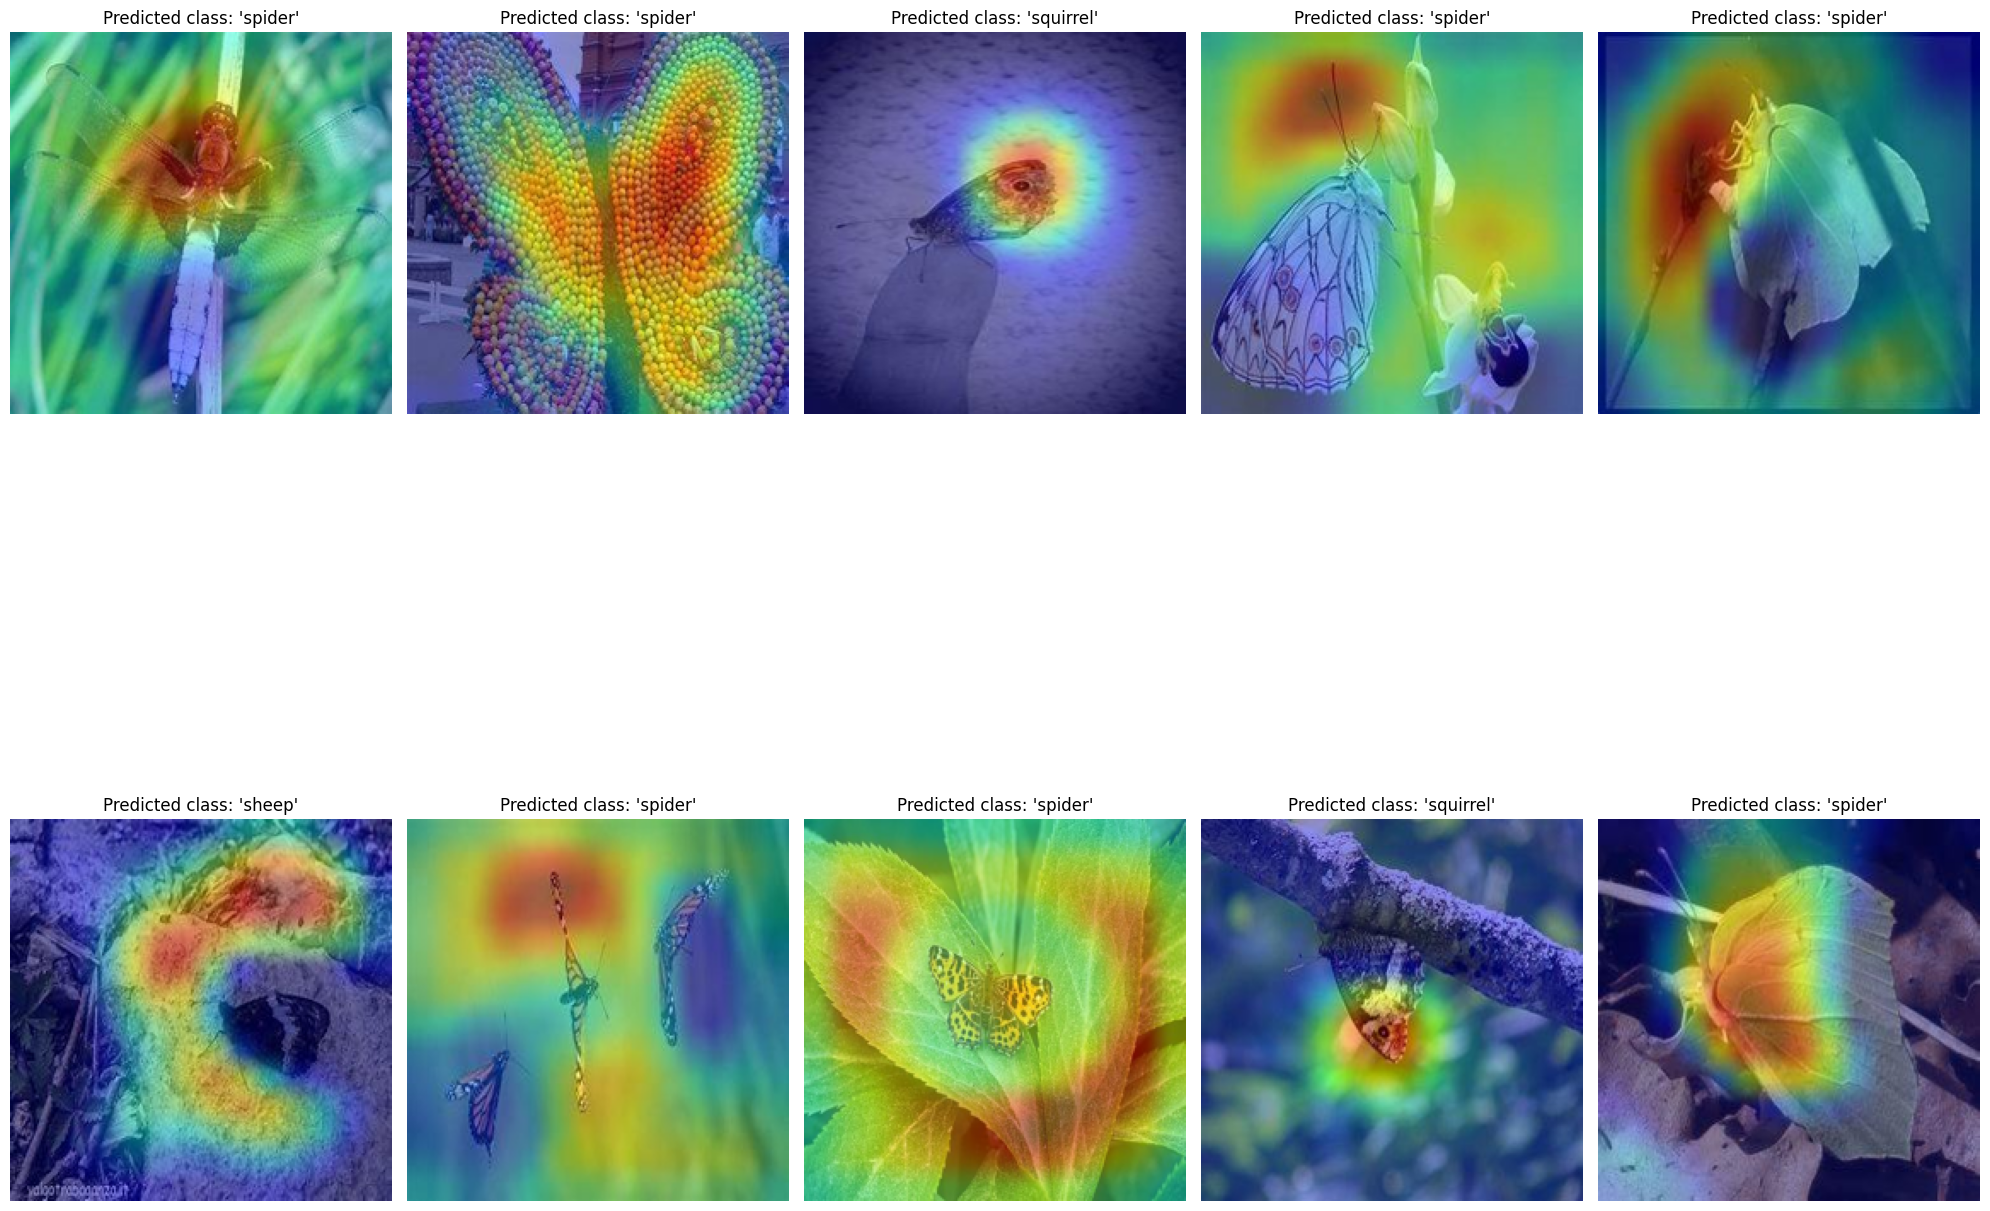

In [13]:
import os
import matplotlib.pyplot as plt
from PIL import Image
#'dog','butterfly','cat','chicken','cow','elephant','sheep','spider','squirrel',
class_names = ['butterfly']
#class_name = 'dog'
for class_name in class_names:
    folder_path = rf'10missclassified/{class_name}'
    if os.path.exists(folder_path):
        file_list = os.listdir(folder_path)


        for filename in file_list:
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)


    images = get_10_missclassified_images_for_path(class_name)
    get_gradcam_for_list_of_missclassified_images(images,class_name,folder_path)

In [11]:
import tensorflow as tf

# Set the GPU memory growth option
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized
